## Gradient-Based Mesh Optimization

FlexiCubes is an isosurface representation designed for gradient-based mesh optimization, where we iteratively
optimize for a 3D surface mesh by representing it as the isosurface of a scalar field. Essentially, this paradigm allows objectives to be directly evaluated on the extracted surface, while offering the flexibility to optimize over meshes with different topologies.

In this tutorial, we demonstrate how to reconstruct an unknown mesh using multiview masks and depth supervision with FlexiCubes. Note that in our paper, we demonstrate more objectives that FlexiCubes can optimize for a variety of applications.

We begin by importing the necessary packages and defining the hyperparameters for optimization.

In [1]:
import torch
import tqdm
import numpy as np
import kaolin as kal
from matplotlib import pyplot as plt

import render
import loss

iter = 1000
batch = 8
train_res = [2048, 2048]
learning_rate = 0.01
voxel_grid_res = 64
device = 'cuda'
sdf_regularizer = 0.2

Next, we load the reference mesh and initialize a FlexiCubes object. We will be optimizing its SDF, weights, and deformations to fit the reference mesh. In this example, we are directly applying gradient descents on these parameters. Alternatively, you can parameterize them using a network of your choice and optimize the network weights instead (Please refer to the GET3D GitHub page for more details).

In [2]:
gt_mesh = kal.io.obj.import_mesh('data/inputmodels/block.obj').cuda()
vertices = gt_mesh.vertices
vmin, vmax = vertices.min(dim=0)[0], vertices.max(dim=0)[0]
scale = 1.8 / torch.max(vmax - vmin).item()
vertices = vertices - (vmax + vmin) / 2 # Center mesh on origin
gt_mesh.vertices = vertices * scale # Rescale to [-0.9, 0.9]

fc = kal.non_commercial.FlexiCubes(device)
x_nx3, cube_fx8 = fc.construct_voxel_grid(voxel_grid_res)
x_nx3 *= 2 # scale up the grid so that it's larger than the target object
sdf = torch.rand_like(x_nx3[:,0]) - 0.1 # randomly initialize SDF
sdf = torch.nn.Parameter(sdf.clone().detach(), requires_grad=True)
# set per-cube learnable weights to zeros
weight = torch.zeros((cube_fx8.shape[0], 21), dtype=torch.float, device='cuda') 
weight = torch.nn.Parameter(weight.clone().detach(), requires_grad=True)

#  Retrieve all the edges of the voxel grid; these edges will be utilized to 
#  compute the regularization loss in subsequent steps of the process.
all_edges = cube_fx8[:, fc.cube_edges].reshape(-1, 2) 
grid_edges = torch.unique(all_edges, dim=0)

We now do random initiation for the optimization

In [3]:
deform = torch.nn.Parameter(torch.zeros_like(x_nx3), requires_grad=True)
grid_verts = x_nx3 + (2-1e-8) / (voxel_grid_res * 2) * torch.tanh(deform) # apply deformation to the grid vertices
vertices, faces, L_dev = fc(
    grid_verts, sdf, cube_fx8, voxel_grid_res, beta=weight[:,:12], alpha=weight[:,12:20],
    gamma_f=weight[:,20], training=False) # run isosurfacing to extract the mesh
init_mesh = kal.rep.SurfaceMesh(vertices=vertices, faces=faces)

Let's extract the meshes from the initial FlexiCubes grid to see what it looks like. The initial mesh topology (on the left) is very different from our reference (on the right). Don't worry, it will converge to the reference in the end! 

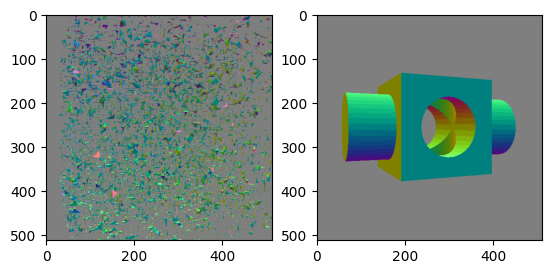

In [4]:
camera = render.get_rotate_camera(0)
f, ax = plt.subplots(1, 2)
output = render.render_mesh(init_mesh, camera, [512, 512], return_types=['normals'])
ax[0].imshow(((output['normals'][0] + 1) / 2.).cpu().detach())
output = render.render_mesh(gt_mesh, camera, [512, 512], return_types=['normals'])
ax[1].imshow(((output['normals'][0] + 1) / 2.).cpu().detach())
plt.show()

We can also visualize interactively with [kaolin's interactive visualizer](https://kaolin.readthedocs.io/en/latest/modules/kaolin.visualize.html), by moving around the camera and adjusting a wireframe to see the topology of the meshes.

In [5]:
render.SplitVisualizer(init_mesh, gt_mesh, 512, 512).show(camera)

Output()

The last thing before we start the optimization is to set up the optimizers and a differentiable renderer.

In [6]:
def lr_schedule(iter):
    return max(0.0, 10 ** (-(iter) * 0.0002)) # Exponential falloff from [1.0, 0.1] over 5k epochs.    
optimizer = torch.optim.Adam([sdf, weight, deform], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: lr_schedule(x)) 

Now, let's execute the actual optimization loop. At every iteration, we perform the following steps:

* Sample random camera poses to render both the reference and ground truth images.
* Extract the mesh with FlexiCubes, as we did above.
* Render the meshes and evaluate the reconstruction and regularization losses (please see inline comments for more details).

In [7]:
intermediate_results = [init_mesh]
for it in tqdm.tqdm(range(iter)): 
    optimizer.zero_grad()
    # sample random camera poses
    cameras = render.get_random_camera_batch(batch, iter_res=train_res, device=device)
    
    # render gt mesh at sampled views
    target = render.render_mesh(gt_mesh, cameras, train_res)

    # extract and render FlexiCubes mesh
    grid_verts = x_nx3 + (2-1e-8) / (voxel_grid_res * 2) * torch.tanh(deform)
    vertices, faces, L_dev = fc(
        grid_verts, sdf, cube_fx8, voxel_grid_res, beta=weight[:,:12], alpha=weight[:,12:20],
        gamma_f=weight[:,20], training=True)
    flexicubes_mesh = kal.rep.SurfaceMesh(vertices=vertices, faces=faces)
    buffers = render.render_mesh(flexicubes_mesh, cameras, train_res)

    # evaluate reconstruction loss
    mask_loss = (buffers['mask'] - target['mask']).abs().mean() # mask loss
    depth_loss = (((((buffers['depth'] - (target['depth']))* target['mask'])**2).sum(-1)+1e-8)).sqrt().mean() * 10 # depth loss
    # evaluate regularization losses
    t_iter = it / iter
    # this is the regularization loss described in Equation 2 of the nvdiffrec paper by Munkberg et al., which serves to remove internal floating elements that are not visible to the user.
    sdf_weight = sdf_regularizer - (sdf_regularizer - sdf_regularizer/20)*min(1.0, 4.0 * t_iter)
    reg_loss = loss.sdf_reg_loss(sdf, grid_edges).mean() * sdf_weight 

    reg_loss += L_dev.mean() * 0.5 # L_dev as in Equation 8 of our paper
    reg_loss += (weight[:,:20]).abs().mean() * 0.1 # regularize weights to be zeros to improve the stability of the optimization process
    total_loss = mask_loss + depth_loss + reg_loss
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    if (it + 1) % 20 == 0: # save intermediate results every 100 iters
        with torch.no_grad():
            # run the mesh extraction again with the parameter 'training=False' so that each quadrilateral face is divided into two triangles, as opposed to the four triangles during the training phase.
            vertices, faces, L_dev = fc(
                grid_verts, sdf, cube_fx8, voxel_grid_res, beta=weight[:,:12], alpha=weight[:,12:20], gamma_f=weight[:,20], training=False)
            intermediate_results.append(kal.rep.SurfaceMesh(vertices, faces))

100%|████████████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.34it/s]


Let's now visualize how the isosurface of FlexiCubes evolves during optimization. As you can see, it converges smoothly to the reference mesh, successfully recovering all sharp features.

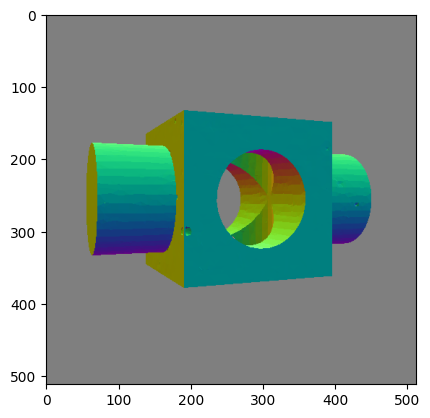

In [8]:
camera = render.get_rotate_camera(0)
output = render.render_mesh(intermediate_results[-1], camera, [512, 512], return_types=['normals'])
plt.imshow(((output['normals'][0] + 1) / 2.).cpu().detach())

With the interactive visualizer we can observe the progress over the training

In [9]:
render.TimelineVisualizer(intermediate_results, 512, 512).show(camera)

Output()